In [1]:
from PIL import Image
import numpy as np
import os
import torch
from diffusers import DDIMScheduler,StableDiffusionXLPipeline,StableDiffusionXLInpaintPipeline
from diffusers.utils import load_image
from torchvision.io import read_image, ImageReadMode
from masactrl.masactrl import MutualSelfAttentionControlMask_An_aug_XL
from masactrl.masactrl_utils import regiter_attention_editor_diffusers
import torch.nn.functional as F
import cv2
from torchvision.utils import save_image
from torchvision.io import read_image
from torchvision.transforms.functional import gaussian_blur
from pytorch_lightning import seed_everything
from matplotlib import pyplot as plt
torch.cuda.set_device(0)  # set the GPU device

/usr/local/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-30 08:29:01.980529: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-30 08:29:03.225991: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dtype = torch.float16
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
#scheduler = DPMSolverMultistepScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear",solver_order=3)
base = StableDiffusionXLInpaintPipeline.from_pretrained(
    "/hy-tmp/stable-diffusion-xl-base-1.0",
    custom_pipeline="/hy-tmp/MyREMOVAL/SDXL_inp_pipeline.py",
    scheduler=scheduler,
    variant="fp16",
    use_safetensors=True,
    torch_dtype=dtype,
).to(device)
base.enable_model_cpu_offload()
""" 
refiner = StableDiffusionXLInpaintPipeline.from_pretrained(
    "/hy-tmp/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base.text_encoder_2,
    scheduler=scheduler,
    vae=base.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
).to(device) """


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]


' \nrefiner = StableDiffusionXLInpaintPipeline.from_pretrained(\n    "/hy-tmp/stable-diffusion-xl-refiner-1.0",\n    text_encoder_2=base.text_encoder_2,\n    scheduler=scheduler,\n    vae=base.vae,\n    torch_dtype=torch.float16,\n    use_safetensors=True,\n    variant="fp16",\n).to(device) '

In [3]:
""" #freeU
from free_lunch_utils import register_free_upblock2d, register_free_crossattn_upblock2d
register_free_upblock2d(base, b1=1.3, b2=1.4, s1=0.9, s2=0.2)
register_free_crossattn_upblock2d(base, b1=1.3, b2=1.4, s1=0.9, s2=0.2) """

In [18]:
seed=777
g = torch.Generator('cuda').manual_seed(seed)
def load_image(image_path, device):
    image = read_image(image_path)
    image = image[:3].unsqueeze_(0).float() / 127.5 - 1.  # [-1, 1]
    if image.shape[1] != 3:
        image = image.expand(-1, 3, -1, -1)
    image = F.interpolate(image, (1024, 1024))
    image = image.to(dtype).to(device)
    return image

def load_mask(mask_path, device):
    mask = read_image(mask_path,mode=ImageReadMode.GRAY)
    mask = mask.unsqueeze_(0).float() / 255.  # 0 or 1
    mask = F.interpolate(mask, (1024, 1024))
    mask = gaussian_blur(mask, kernel_size=(9, 9))
    mask[mask < 0.1] = 0
    mask[mask >= 0.1] = 1
    mask = mask.to(dtype).to(device)
    return mask


sample = "bertrand1024"
prompt = ""
out_dir = f"./workdir_xl/{sample}/"
os.makedirs(out_dir, exist_ok=True)
sample_count = len(os.listdir(out_dir))
out_dir = os.path.join(out_dir, f"sample_{sample_count}")
os.makedirs(out_dir, exist_ok=True)
#SOURCE_IMAGE_PATH = "/hy-tmp/MyREMOVAL/result.png"
SOURCE_IMAGE_PATH = f"/hy-tmp/MyREMOVAL/examples/img/{sample}.png"
MASK_PATH = f"/hy-tmp/MyREMOVAL/examples/mask/{sample}_mask.png"
SOURCE_IMAGE_PATH = "/hy-tmp/DATA/sample/008f6d9128e5aa5f_m0bt9lr_accad52a.jpg"
MASK_PATH = "/hy-tmp/DATA/sample/008f6d9128e5aa5f_m0bt9lr_accad52a_mask.png"
#004130acea29204f_m0bt9lr_64749b83
source_image = load_image(SOURCE_IMAGE_PATH, device)
mask_an = load_mask(MASK_PATH, device)

In [19]:
# inference the synthesized image with MasaCtrl
strength = 0.8
num_inference_steps = 50
START_STEP = 0
END_STEP = int(strength*num_inference_steps)
LAYER = 34 #0~23down,24~33mid,34~69up
END_LAYER = 70
#removelist=[6]
removelist=list(range(24,34))
layer_idx=list(range(LAYER, END_LAYER))
""" 
for i in removelist:
    layer_idx.remove(i) """
# hijack the attention module
editor = MutualSelfAttentionControlMask_An_aug_XL(START_STEP, END_STEP, LAYER, END_LAYER,layer_idx= layer_idx, mask=mask_an,model_type="SDXL",ss_scale=0.4)
regiter_attention_editor_diffusers(base, editor)

In [20]:
#image_s = Image.open(SOURCE_IMAGE_PATH).convert('RGB')
#mask = Image.open(MASK_PATH)
image = base(
    prompt=prompt,
    image=source_image,
    height=1024,
    width=1024,
    rm_guidance_scale=9,
    strength=strength,
    mask_image=mask_an,
    generator=g,
    num_inference_steps=num_inference_steps,
    guidance_scale=1,
    output_type='pt'
).images[0]


In [21]:
def make_redder(img, mask, increase_factor=0.4):
    # 创建一个拷贝以避免修改原始图像
    img_redder = img.clone()
    mask_expanded = mask.expand_as(img)
    # 增加红色分量（第一个通道）在 mask 为 1 的区域
    img_redder[0][mask_expanded[0] == 1] = torch.clamp(img_redder[0][mask_expanded[0] == 1] + increase_factor, 0, 1)
    
    return img_redder
img = (source_image* 0.5 + 0.5).squeeze(0)
mask_red = mask_an.squeeze(0)
img_redder = make_redder(img, mask_red)
#save_image(img_redder, os.path.join(out_dir, "redder.png"))

In [22]:
from torchvision.transforms.functional import to_pil_image, to_tensor
from PIL import Image, ImageFilter
pil_mask = to_pil_image(mask_an.squeeze(0))
pil_mask_blurred = pil_mask.filter(ImageFilter.GaussianBlur(radius=15))
mask_blurred = to_tensor(pil_mask_blurred).unsqueeze_(0).to(mask_an.device)
msak_f = 1-(1-mask_an)*(1-mask_blurred)

Syntheiszed images are saved in ./workdir_xl/bertrand1024/sample_12


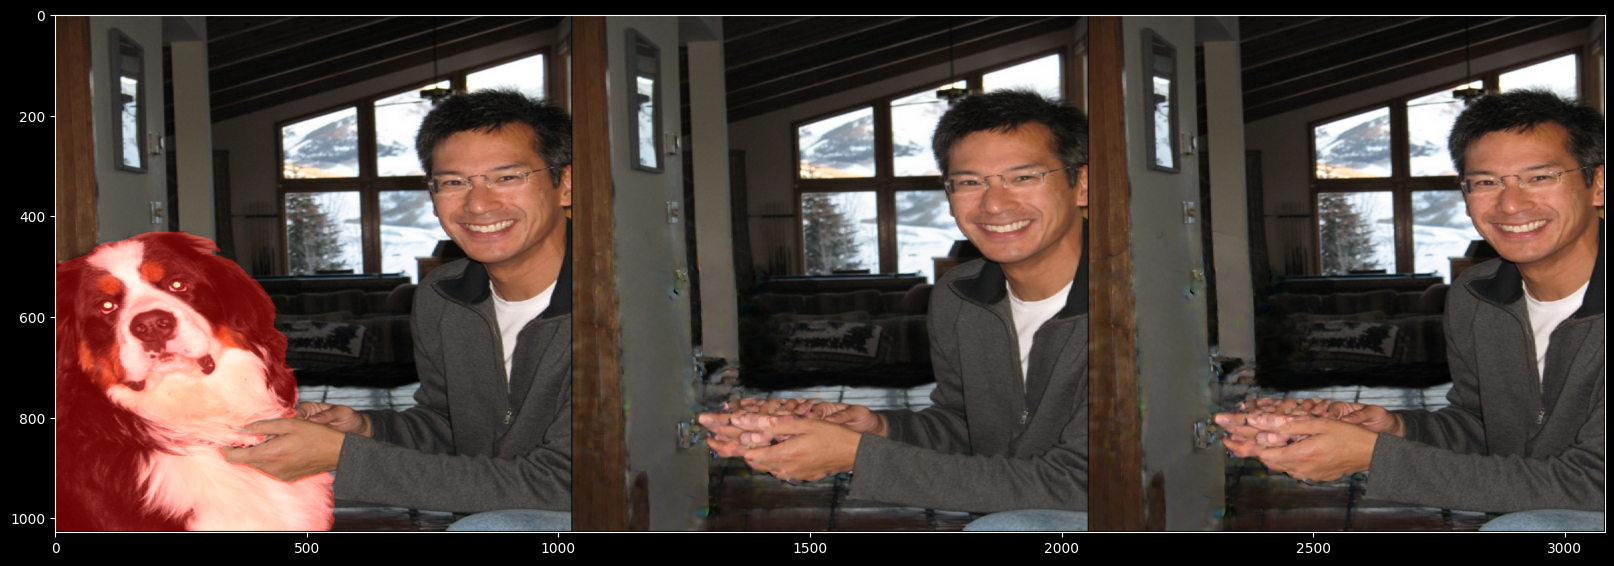

In [23]:
image_1=image.unsqueeze(0)
out_tile = msak_f * image_1 + (1 - msak_f) * (source_image* 0.5 + 0.5)
out_image = torch.concat([img_redder.unsqueeze(0),
                         image_1,
                         out_tile],
                         dim=0)
save_image(out_image, os.path.join(out_dir, f"all_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[0], os.path.join(out_dir, f"source_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[1], os.path.join(out_dir, f"anonymous_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[2], os.path.join(out_dir, f"anonymous_tile_step{END_STEP}_layer{LAYER}.png"))
print("Syntheiszed images are saved in", out_dir)
img_ori = cv2.imread(os.path.join(out_dir, f"all_step{END_STEP}_layer{LAYER}.png"))
img_ori = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20, 26))
plt.imshow(img_ori)

In [24]:
""" prompt=""
num_inference_steps = 50
high_noise_frac = 0.8
image = base(
    prompt=prompt,
    latents = latents,
    image=source_image,
    height=1024,
    width=1024,
    strength=1,
    mask_image=mask,
    generator=g,
    num_inference_steps=num_inference_steps,
    denoising_end = high_noise_frac,
    guidance_scale=1,
    output_type="latent",
).images

image = refiner(
    prompt=prompt,
    image=image,
    mask_image=mask,
    generator=g,
    num_inference_steps=num_inference_steps,
    denoising_start=high_noise_frac,
).images[0]
image.save("/hy-tmp/MyREMOVAL/result_refine.png")
image """

' prompt=""\nnum_inference_steps = 50\nhigh_noise_frac = 0.8\nimage = base(\n    prompt=prompt,\n    latents = latents,\n    image=source_image,\n    height=1024,\n    width=1024,\n    strength=1,\n    mask_image=mask,\n    generator=g,\n    num_inference_steps=num_inference_steps,\n    denoising_end = high_noise_frac,\n    guidance_scale=1,\n    output_type="latent",\n).images\n\nimage = refiner(\n    prompt=prompt,\n    image=image,\n    mask_image=mask,\n    generator=g,\n    num_inference_steps=num_inference_steps,\n    denoising_start=high_noise_frac,\n).images[0]\nimage.save("/hy-tmp/MyREMOVAL/result_refine.png")\nimage '